# Simple Version

Summary: Just multiply the number of people on day 3 by 2, to get an estimate of the number on day 10 :)

Here we get the average for other days

In [87]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime


ratios = []
days = range(15)
for day in days:
  #  print("day %d" % day)
    Xs = []
    ys = []
    for fname in glob.glob('*.csv'):
        
        data = pd.read_csv(fname)
        datetime_object = datetime.strptime(data.date[0], '%d-%m-%Y')
      #  (datetime.now() - datetime_object).days
        X = np.r_[data[1:5].total.values,(datetime.now() - datetime_object).days]
        y = data.total[day]
     #   print(" - accessing %s (total %d)" % (fname, y))
        Xs.append(X)
        ys.append(y)
    Xs = np.array(Xs)
    ys = np.array(ys)[:,None]
    
    keep = Xs[:,3]>30 #chuck out surveys with less than 30 people on day 4
    ys = ys[keep,:]
    Xs = Xs[keep,:]
   # print(Xs.shape[0])
    #keep = Xs[:,2]<30 #chuck out surveys more than a month ago
    #ys = ys[keep,:]
    #Xs = Xs[keep,:]
    ratios.append(ys[:,0]/Xs[:,1])
    
ratio = np.median(ratios,1)
indxmin = int(np.round(len(ratios[0])*0.125))
ratiomin = np.sort(np.array(ratios),1)[:,indxmin]
indxmax = int(np.round(len(ratios[0])*0.875))
ratiomax = np.sort(np.array(ratios),1)[:,indxmax]
#ratiomin = np.min(ratios,1)
#ratiomax = np.max(ratios,1)

In [90]:
[indxmin,indxmax]

[1, 7]

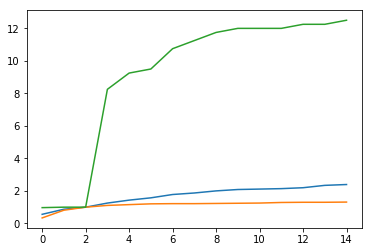

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(ratio)
plt.plot(ratiomin)
plt.plot(ratiomax)

In [92]:
day = 10 #day of interest
day3 = 40 #number of people on day 3

#75% confidence interval:
print("I expect %d people on day %d (maybe between: %d and %d [75%% confidence])" % (ratio[day]*day3, day, ratiomin[day]*day3, ratiomax[day]*day3))

I expect 84 people on day 10 (maybe between: 50 and 480 [75% confidence])


# You don't need anything below this point :)

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  3.]),
 array([ 0.50732598,  0.72129206,  0.93525813,  1.14922421,  1.36319029,
         1.57715637,  1.79112244,  2.00508852,  2.2190546 ,  2.43302068,
         2.64698675]),
 <a list of 10 Patch objects>)

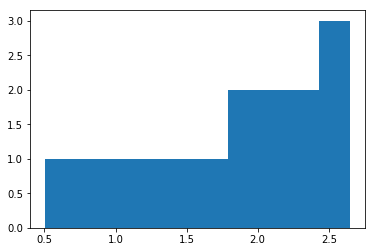

In [66]:
plt.hist(ratio,10)

Almost no data is here...
in particular there's only 2-3 with more than 500 responses...

# Clever stuff using Gaussian Processes!

In [6]:
import GPy
k = GPy.kern.RBF(3,ARD=True)
m = GPy.models.GPRegression(Xs[0:-1,:],ys[0:-1,:],k)
m.rbf.lengthscale = 1000.0
m.Gaussian_noise = 100.0
m.optimize()


 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1
 /home/mike/GPy/GPy/kern/src/stationary.py:158: RuntimeWarning:overflow encountered in true_divide
 /home/mike/GPy/GPy/kern/src/stationary.py:130: RuntimeWarning:invalid value encountered in add


In [7]:
m.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],985.59244545,+ve,
[1],503000.49908762,+ve,
[2],9488.95224899,+ve,


In [8]:
Xs[-1:,:]

array([[398, 489,  49]])

In [9]:
pred,var = m.predict_noiseless(Xs[-1:,:])
#noiseless prediction a bit dubious. but I think people will be upset by large uncertainty otherwise...
print("In 10 days I would expect %0.0f (between %0.0f and %0.0f people, 95%% CI)" % (pred, pred-np.sqrt(var)*1.96,pred+np.sqrt(var)*1.96,))
print("Actual: %d" % ys[-1:,:])

In 10 days I would expect 1314 (between 949 and 1679 people, 95% CI)
Actual: 1804


New attempt, using all data.
We assume we've had 20 & 30 people on days 2 and 3... how many on day 10 (in 7 days)?

In [ ]:

k = GPy.kern.RBF(3,ARD=True)
m = GPy.models.GPRegression(Xs,ys,k)
m.rbf.lengthscale = 100.0
m.Gaussian_noise = 10.0
m.optimize()

In [ ]:
newX = np.array([[20,30,-7]]) #-7 = 7 days into future.
pred,var = m.predict_noiseless(newX) #warning: shouldn't be using noiseless...
print("In 10 days I would expect %0.0f (between %0.0f and %0.0f people, 95%% CI)" % (pred, pred-np.sqrt(var)*1.96,pred+np.sqrt(var)*1.96,))
print("Actual: don't know")

In [20]:
50*2

100